In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os

# disable TF logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from constants import *

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Map inputs to layers

Here, we will use a dictionary of inputs where keys are column names and values are input layers.

### Creating the dataset from CSV

In [29]:
with FEATURE_DESC.open() as f:
    FD = json.load(f)
    FDD = FD["deep"]
    FDW = FD["wide"]

In [5]:
def dataset_from_file(filename, batch_size, label_name, mappers=[]):
    dataset = tf.data.experimental.make_csv_dataset(
        filename, batch_size, label_name=label_name
    )

    if mappers:
        if not isinstance(mappers, (list, tuple)):
            mappers = [mappers]
        for mapper in mappers:
            dataset = dataset.map(
                mapper, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False
            )
    return dataset.cache()


def stack_mapper(features, label):
    for feat in FDD["MH"]:
        fname = feat["name"]
        columns = feat["columns"]
        raw_features = [features.pop(name) for name in columns]
        features[fname] = tf.stack(raw_features, axis=1)
    return features, label

In [6]:
train, val, test = (
    dataset_from_file(str(path), BATCH_SIZE, FD["label"], stack_mapper)
    for path in (DATA_TRAIN, DATA_VAL, DATA_TEST)
)

Metal device set to: AMD Radeon Pro 5300M


## Create input layers

In [7]:
with DATA_VOCAB.open() as f:
    VOCAB = json.load(f)

In [8]:
def get_features():
    DTYPES = {
        "I": tf.int32,
        "S": tf.string,
    }

    features = {}

    for fname in FDD["N"]:
        features[fname] = keras.Input(shape=(), name=fname, dtype=tf.float32)

    for dtype, features_desc in FDD["C"].items():
        for feature in features_desc:
            fname = feature["name"]
            features[fname] = keras.Input(shape=(), name=fname, dtype=DTYPES[dtype])

    for fname in FDD["E"]:
        features[fname] = keras.Input(shape=(), name=fname, dtype=tf.string)

    for feature in FDD["MH"]:
        fname = feature["name"]
        columns = feature["columns"]
        features[fname] = keras.Input(
            shape=(len(columns),), name=fname, dtype=tf.float32
        )

    return features

# Deep model

In [35]:
def deep_inputs(features):
    LTYPES = {
        "I": keras.layers.IntegerLookup,
        "S": keras.layers.StringLookup,
    }

    inputs = {}
    for fname in FDD["N"]:
        inputs[fname] = tf.expand_dims(features[fname], -1)

    for ltype, features_desc in FDD["C"].items():
        for feature in features_desc:
            fname = feature["name"]
            embed = feature["embed"]
            if feature.get("drop", False):
                continue
            values = VOCAB[fname]
            l = LTYPES[ltype](
                vocabulary=values,
                output_mode="int" if embed else "one_hot",
                mask_token=None,
            )
            if embed:
                l = l(features[fname])
                dim = int(1.6 * (len(values) ** 0.5))
                embedding = keras.layers.Embedding(
                    len(values) + 1,
                    dim,
                )
                l = embedding(l)
            else:
                l = l(tf.expand_dims(features[fname], -1))

            inputs[fname] = l

    for fname in FDD["E"]:
        vocab_size = 10000
        sequence_length = 10
        vectorize_layer = keras.layers.TextVectorization(
            max_tokens=vocab_size,
            output_mode="int",
            output_sequence_length=sequence_length,
        )
        l = vectorize_layer(features[fname])

    for feature in FDD["MH"]:
        fname = feature["name"]
        embed = feature["embed"]
        if embed:
            in_len = features[fname].shape[1]
            dim = int(1.6 * (in_len ** 0.5))
            embedding = keras.layers.Dense(
                dim,
                use_bias=False,
            )
            l = embedding(features[fname])
        else:
            l = features[fname]

        inputs[fname] = l

    return keras.layers.concatenate(inputs.values())

In [10]:
def get_hidden_layers_deep(features):
    layer = deep_inputs(features)
    for lsize in DEEP_LSIZE:
        layer = keras.layers.BatchNormalization()(layer)
        layer = keras.layers.Dense(lsize, activation="relu")(layer)
        layer = keras.layers.Dropout(DROPOUT)(layer)
    return layer


def get_model_d():
    features = get_features()
    layer = get_hidden_layers_deep(features)
    layer = keras.layers.Dense(1, activation="sigmoid")(layer)
    return keras.Model(inputs=features, outputs=layer, name="D")

In [48]:
if DEEP_LOAD_FROM_DISK:
    model_d = tf.keras.models.load_model(DEEP_MODEL_PATH)

In [12]:
if not DEEP_LOAD_FROM_DISK:
    model_d = get_model_d()
    model_d.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
    )
    model_d.summary()
    keras.utils.plot_model(model_d, to_file=DEEP_IMG_PATH)

In [13]:
if not DEEP_LOAD_FROM_DISK:
    with tf.device("/GPU:0"):
        model_d.fit(
            train,
            epochs=EPOCHS,
            steps_per_epoch=STEPS_EPOCH,
            validation_data=val,
            validation_steps=VAL_STEPS,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss", patience=5, restore_best_weights=True
                )
            ],
            workers=WORKERS,
        )

In [14]:
if not DEEP_LOAD_FROM_DISK:
    model_d.save(DEEP_MODEL_PATH)

In [15]:
if not DEEP_LOAD_FROM_DISK:
    with tf.device("/CPU:0"):
        model_d.evaluate(test, workers=WORKERS)

# Deep & Wide model

In [18]:
class CrossLayer(keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs, trainable=False)

    def call(self, *layers):
        l0 = layers[0]
        batch_size = l0.shape[0]
        
        for l1 in layers[1:]:
            l0_dim = tf.shape(l0)[1]
            l1_dim = tf.shape(l1)[1]
            l0 = tf.expand_dims(l0, -1)  # shape [batch_size, l0_dim, 1]
            l1 = tf.expand_dims(l1, 1)   # shape [batch_size, 1, l1_dim]
            
            xmat = tf.matmul(l0, l1)     # shape [batch_size, l0_dim, l1_dim]
            l0 = tf.reshape(xmat, shape=[-1, l0_dim * l1_dim])  # shape [batch_size, l0_dim * l1_dim]

        return l0


def wide_inputs(features):
    LTYPES = {
        "I": keras.layers.IntegerLookup,
        "S": keras.layers.StringLookup,
    }

    inputs = {}
    for fname in FDW["B"]:
        l = tf.expand_dims(features[fname], -1, name="w_" + fname)
        if len(l.shape) > 2:
            dims = 1
            for d in l.shape[1:]:
                dims *= d
            l = tf.reshape(l, shape=(-1, dims))
        inputs[fname] = l

    for ltype, features_desc in FDW["C"].items():
        for feature in features_desc:
            fname = feature["name"]
            values = VOCAB[fname]
            l = LTYPES[ltype](
                vocabulary=values,
                output_mode="one_hot",
                mask_token=None,
                name="w_" + fname,
            )
            l = l(tf.expand_dims(features[fname], -1))
            inputs[fname] = l
    
    for xfeats in FDW["X"]:
        layers = [inputs[x] for x in xfeats]
        fname = ".".join(xfeats)
        l = CrossLayer(name="w_" + fname)
        inputs[fname] = l(*layers)

    return keras.layers.concatenate(inputs.values())

In [19]:
def get_layers_wide(features):
    layer = wide_inputs(features)
    return layer


def get_model_wd():
    features = get_features()
    dlayer = get_hidden_layers_deep(features)
    wlayer = get_layers_wide(features)
    layer = keras.layers.concatenate([dlayer, wlayer])
    layer = keras.layers.Dense(1, activation="sigmoid")(layer)
    return keras.Model(inputs=features, outputs=layer, name="WD")

Model: "WD"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Hour (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 Month (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DoW (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 User_Age (InputLayer)          [(None,)]            0           []                               
                                                                                                 

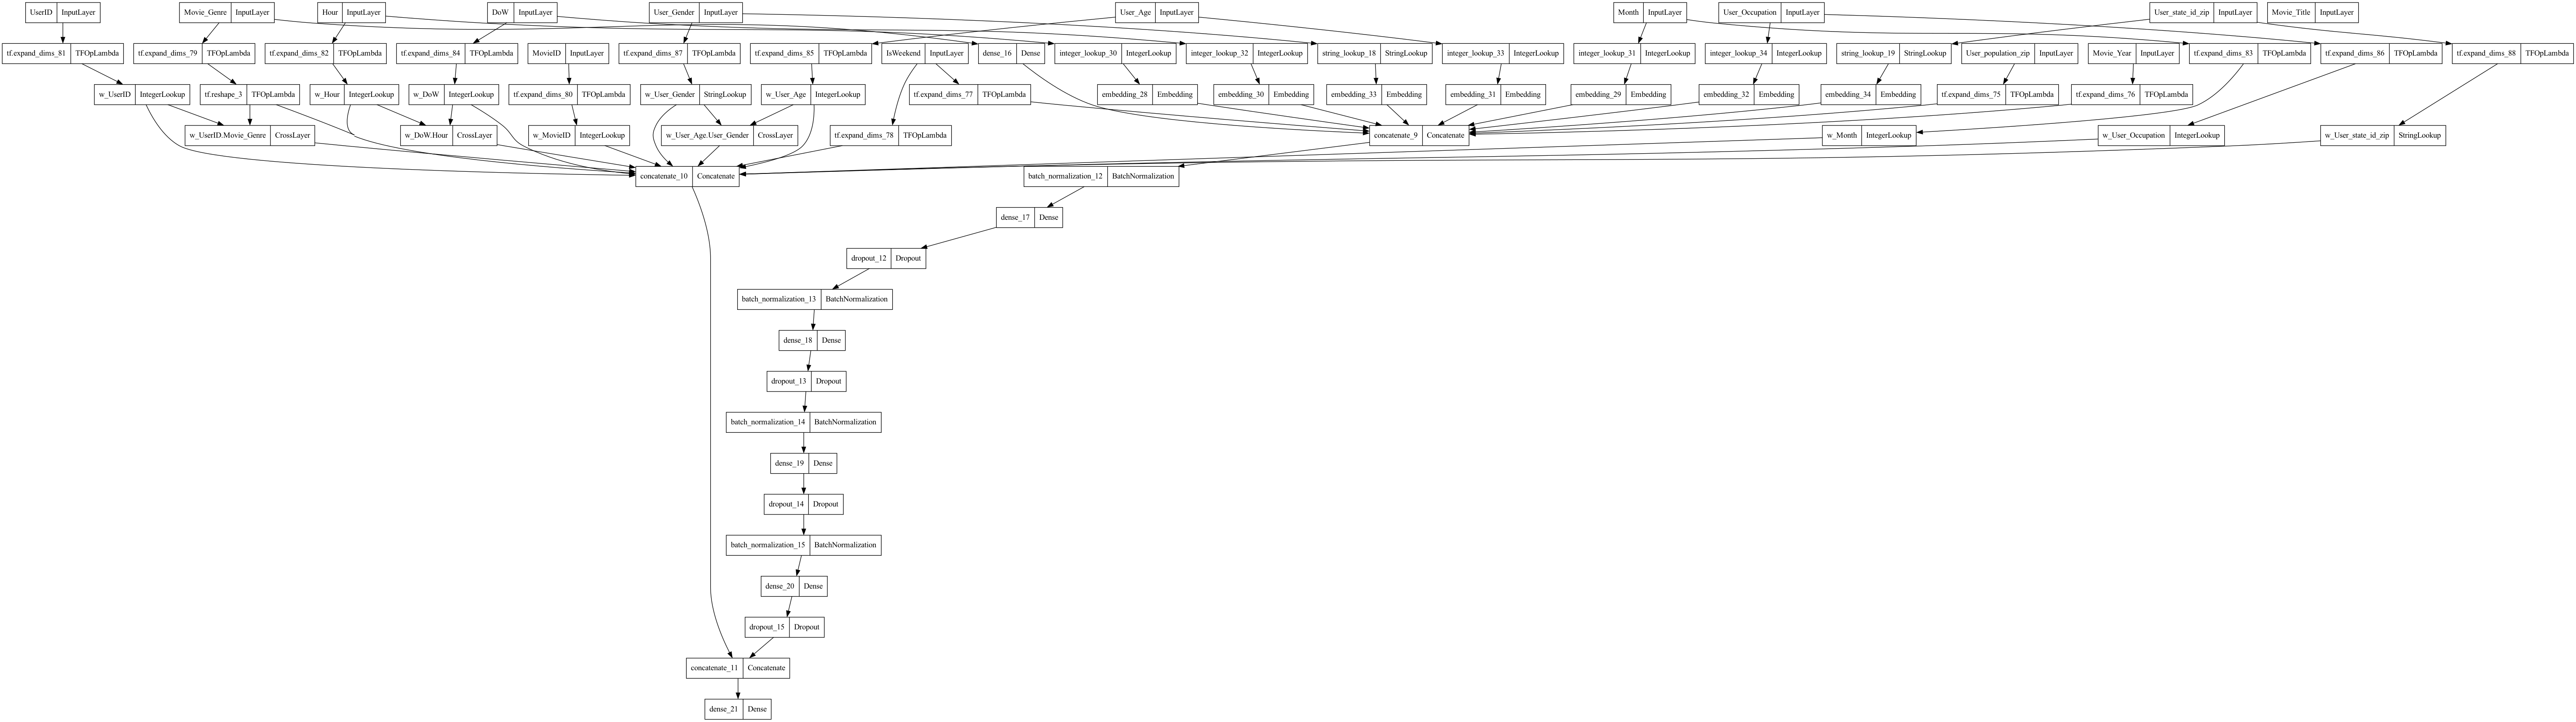

In [38]:
model_wd = get_model_wd()
model_wd.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
    )
model_wd.summary()
keras.utils.plot_model(model_wd, to_file=DW_IMG_PATH)

In [24]:
with tf.device("/CPU:0"):
    model_wd.fit(
        train,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_EPOCH,
        validation_data=val,
        validation_steps=VAL_STEPS,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=5, restore_best_weights=True
            )
        ],
        workers=WORKERS,
    )

Epoch 1/20
1024/1024 [==============================] - 54s 50ms/step - loss: 0.5935 - binary_accuracy: 0.6810 - auc_1: 0.7325 - val_loss: 0.6305 - val_binary_accuracy: 0.6436 - val_auc_1: 0.6825
Epoch 2/20
1024/1024 [==============================] - 54s 53ms/step - loss: 0.5746 - binary_accuracy: 0.7011 - auc_1: 0.7488 - val_loss: 0.6212 - val_binary_accuracy: 0.6675 - val_auc_1: 0.7064
Epoch 3/20
1024/1024 [==============================] - 54s 52ms/step - loss: 0.5569 - binary_accuracy: 0.7134 - auc_1: 0.7693 - val_loss: 0.5979 - val_binary_accuracy: 0.6770 - val_auc_1: 0.7279
Epoch 4/20
1024/1024 [==============================] - 50s 48ms/step - loss: 0.5539 - binary_accuracy: 0.7156 - auc_1: 0.7817 - val_loss: 0.6116 - val_binary_accuracy: 0.6663 - val_auc_1: 0.7066
Epoch 5/20
1024/1024 [==============================] - 50s 49ms/step - loss: 0.5461 - binary_accuracy: 0.7232 - auc_1: 0.7914 - val_loss: 0.5993 - val_binary_accuracy: 0.6763 - val_auc_1: 0.7262
Epoch 6/20
1024/1024

In [25]:
model_wd.save(DW_MODEL_PATH)

INFO:tensorflow:Assets written to: models/dw.tf/assets


INFO:tensorflow:Assets written to: models/dw.tf/assets


In [ ]:
with tf.device("/CPU:0"):
    model_wd.evaluate(test, workers=WORKERS)